In [1]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# KNN Implementation
class KNNClassifier:
    def __init__(self, k=3, metric='euclidean'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """Store training data"""
        self.X_train = X
        self.y_train = y
        return self

    def manhattan_distance(self, x1, x2):
        """Calculate L1 (Manhattan) distance"""
        return np.sum(np.abs(x1 - x2), axis=1)

    def euclidean_distance(self, x1, x2):
        """Calculate L2 (Euclidean) distance"""
        return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

    def predict(self, X):
        """Predict class labels for samples in X"""
        predictions = []

        for x in X:
            if self.metric == 'manhattan':
                distances = self.manhattan_distance(self.X_train, x)
            else:  # euclidean
                distances = self.euclidean_distance(self.X_train, x)

            # Get indices of k nearest neighbors
            k_nearest_idx = np.argsort(distances)[:self.k]

            # Get labels of k nearest neighbors
            k_nearest_labels = self.y_train[k_nearest_idx]

            # Majority voting
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            prediction = unique[np.argmax(counts)]
            predictions.append(prediction)

        return np.array(predictions)

    def predict_with_confidence(self, X):
        """Predict and return confidence scores for top predictions"""
        predictions = []
        confidences = []

        for x in X:
            if self.metric == 'manhattan':
                distances = self.manhattan_distance(self.X_train, x)
            else:
                distances = self.euclidean_distance(self.X_train, x)

            k_nearest_idx = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_nearest_idx]

            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            sorted_idx = np.argsort(counts)[::-1]

            top_class = unique[sorted_idx[0]]
            confidence = counts[sorted_idx[0]] / self.k

            predictions.append(top_class)
            confidences.append((top_class, confidence))

        return np.array(predictions), confidences

# Simple image loading
def load_jpg_image(filepath):
    """Load JPG image using numpy and struct"""
    try:
        with open(filepath, 'rb') as f:
            img_data = f.read()

        # Find SOF0 (Start of Frame) marker to get image dimensions
        import matplotlib.image as mpimg
        img = mpimg.imread(filepath)
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Load and preprocess data
def load_and_preprocess_data(data_dir='/content/drive/MyDrive/animal_dataset',
                             img_size=32):
    """Load images from directory and convert to grayscale"""
    import matplotlib.image as mpimg
    from matplotlib.colors import rgb_to_hsv

    X = []
    y = []
    class_names = []
    class_mapping = {}

    # Get all class directories
    all_items = os.listdir(data_dir)
    class_dirs = sorted([d for d in all_items
                        if os.path.isdir(os.path.join(data_dir, d))])

    print("Found classes: " + str(class_dirs))

    for class_idx, class_name in enumerate(class_dirs):
        class_path = os.path.join(data_dir, class_name)
        class_mapping[class_idx] = class_name
        class_names.append(class_name)

        img_files = [f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print("Loading " + class_name + ": " + str(len(img_files)) + " images")

        for img_file in img_files:
            try:
                img_path = os.path.join(class_path, img_file)

                # Load image using matplotlib
                img = mpimg.imread(img_path)

                # Handle different image formats
                if len(img.shape) == 3:
                    if img.shape[2] == 4:  # RGBA
                        img = img[:, :, :3]
                    # Convert RGB to grayscale using standard formula
                    img_gray = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]
                else:
                    img_gray = img

                # Resize using simple interpolation (nearest neighbor)
                h, w = img_gray.shape
                h_new, w_new = img_size, img_size

                # Simple resize using numpy slicing
                img_resized = np.zeros((img_size, img_size))
                h_ratio = h / img_size
                w_ratio = w / img_size

                for i in range(img_size):
                    for j in range(img_size):
                        src_i = int(i * h_ratio)
                        src_j = int(j * w_ratio)
                        src_i = min(src_i, h - 1)
                        src_j = min(src_j, w - 1)
                        img_resized[i, j] = img_gray[src_i, src_j]

                # Flatten and normalize
                img_array = img_resized.flatten() / 255.0

                X.append(img_array)
                y.append(class_idx)

            except Exception as e:
                print("Error loading " + img_file + ": " + str(e))
                continue

    print("\nTotal images loaded: " + str(len(X)))
    return np.array(X), np.array(y), class_names, class_mapping

# 5-Fold Cross-Validation
def cross_validation_split(X, y, n_folds=5, random_state=42):
    """Split data into n folds"""
    np.random.seed(random_state)
    n_samples = len(X)
    fold_size = n_samples // n_folds

    folds_X = []
    folds_y = []

    indices = np.random.permutation(n_samples)
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(n_folds):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < n_folds - 1 else n_samples

        # Training: everything except validation fold
        X_train = np.vstack([X_shuffled[:start_idx], X_shuffled[end_idx:]])
        y_train = np.hstack([y_shuffled[:start_idx], y_shuffled[end_idx:]])

        # Validation: current fold
        X_val = X_shuffled[start_idx:end_idx]
        y_val = y_shuffled[start_idx:end_idx]

        folds_X.append((X_train, X_val))
        folds_y.append((y_train, y_val))

    return folds_X, folds_y

def evaluate_cv(X, y, k_values, metrics=['euclidean', 'manhattan'], n_folds=5):
    """Evaluate KNN with cross-validation"""
    results = {metric: {k: [] for k in k_values} for metric in metrics}

    folds_X, folds_y = cross_validation_split(X, y, n_folds)

    for fold in range(n_folds):
        print("Processing fold " + str(fold + 1) + "/" + str(n_folds) + "...", end=" ")

        X_train_fold, X_val_fold = folds_X[fold]
        y_train_fold, y_val_fold = folds_y[fold]

        for metric in metrics:
            for k in k_values:
                knn = KNNClassifier(k=k, metric=metric)
                knn.fit(X_train_fold, y_train_fold)

                predictions = knn.predict(X_val_fold)
                accuracy = np.mean(predictions == y_val_fold)
                results[metric][k].append(accuracy)

        print("Done")

    # Calculate average accuracy
    avg_results = {metric: {} for metric in metrics}
    for metric in metrics:
        for k in k_values:
            avg_results[metric][k] = np.mean(results[metric][k])

    return avg_results

Loading dataset from Colab...
Found classes: ['cat', 'dog', 'panda']
Loading cat: 100 images
Loading dog: 100 images
Loading panda: 103 images

Total images loaded: 303

Dataset Summary:
  Total images: 303
  Image features: 1024 (32x32 grayscale)
  Classes: ['cat', 'dog', 'panda']
  Class distribution: [100 100 103]

Running 5-fold cross-validation...
------------------------------------------------------------
Processing fold 1/5... Done
Processing fold 2/5... Done
Processing fold 3/5... Done
Processing fold 4/5... Done
Processing fold 5/5... Done

Average Accuracy Results (5-Fold Cross-Validation):
   K |   Euclidean (L2) |   Manhattan (L1) |   Difference
------------------------------------------------------------
   1 |           0.3821 |           0.3854 |      -0.0033
   3 |           0.3363 |           0.3560 |      -0.0197
   5 |           0.3529 |           0.3727 |      -0.0198
   7 |           0.3692 |           0.4089 |      -0.0397
   9 |           0.3659 |           0.39

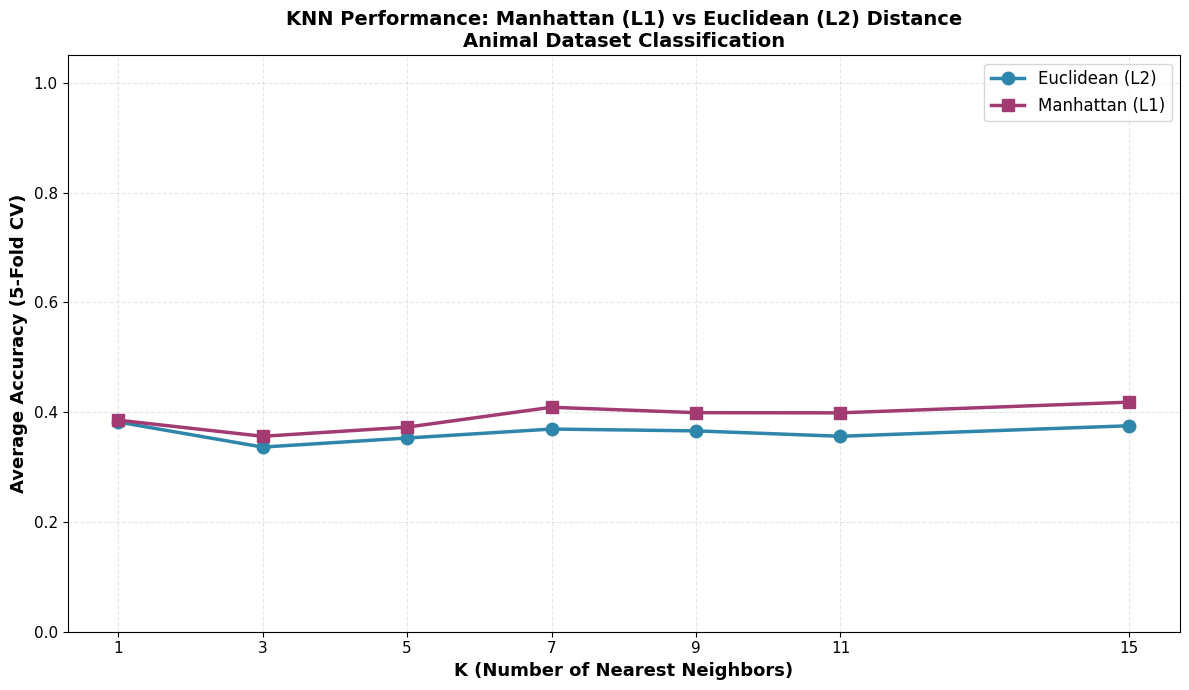


Best Performance:
Euclidean (L2): K= 1 | Accuracy: 0.3821
Manhattan (L1): K=15 | Accuracy: 0.4183

✓ Manhattan (L1) is better with 0.4183 accuracy

Top 5 Predictions on Random Test Samples:
Using MANHATTAN distance with K=15

Sample 1:
  True Class: panda
  Predicted:  dog
  Confidence: 46.67%
  Status:     ✗ WRONG

Sample 2:
  True Class: panda
  Predicted:  dog
  Confidence: 53.33%
  Status:     ✗ WRONG

Sample 3:
  True Class: dog
  Predicted:  dog
  Confidence: 60.00%
  Status:     ✓ CORRECT

Sample 4:
  True Class: panda
  Predicted:  cat
  Confidence: 40.00%
  Status:     ✗ WRONG

Sample 5:
  True Class: dog
  Predicted:  cat
  Confidence: 60.00%
  Status:     ✗ WRONG

Analysis: Which Distance Metric is Better?

Overall Average Accuracy:
  Euclidean (L2): 0.3625
  Manhattan (L1): 0.3913
  Difference:     0.0288

✓ WINNER: Manhattan (L1) Distance

Reasons:
  • Better for high-dimensional sparse data
  • Less sensitive to outliers in pixel values
  • May capture grid-like or block

In [3]:
# Load dataset
print("Loading dataset from Colab...")
data_dir = '/content/drive/MyDrive/animal_dataset'
X, y, class_names, class_mapping = load_and_preprocess_data(data_dir, img_size=32)

print("\nDataset Summary:")
print("  Total images: " + str(len(X)))
print("  Image features: " + str(X.shape[1]) + " (32x32 grayscale)")
print("  Classes: " + str(class_names))
print("  Class distribution: " + str(np.bincount(y)) + "\n")

# Hyperparameter values to test
k_values = [1, 3, 5, 7, 9, 11, 15]

# Cross-validation evaluation
print("Running 5-fold cross-validation...")
print("-" * 60)
avg_results = evaluate_cv(X, y, k_values, metrics=['euclidean', 'manhattan'])

# Print results
print("\n" + "="*60)
print("Average Accuracy Results (5-Fold Cross-Validation):")
print("="*60)
print("{:>4} | {:>16} | {:>16} | {:>12}".format("K", "Euclidean (L2)", "Manhattan (L1)", "Difference"))
print("-" * 60)
for k in k_values:
    eucl_acc = avg_results['euclidean'][k]
    manh_acc = avg_results['manhattan'][k]
    diff = eucl_acc - manh_acc
    print("{:4d} | {:16.4f} | {:16.4f} | {:12.4f}".format(k, eucl_acc, manh_acc, diff))

# Plot results
plt.figure(figsize=(12, 7))

eucl_accs = [avg_results['euclidean'][k] for k in k_values]
manh_accs = [avg_results['manhattan'][k] for k in k_values]

plt.plot(k_values, eucl_accs, 'o-', label='Euclidean (L2)', linewidth=2.5, markersize=9, color='#2E86AB')
plt.plot(k_values, manh_accs, 's-', label='Manhattan (L1)', linewidth=2.5, markersize=9, color='#A23B72')

plt.xlabel('K (Number of Nearest Neighbors)', fontsize=13, fontweight='bold')
plt.ylabel('Average Accuracy (5-Fold CV)', fontsize=13, fontweight='bold')
plt.title('KNN Performance: Manhattan (L1) vs Euclidean (L2) Distance\nAnimal Dataset Classification',
              fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(k_values, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.savefig('knn_comparison.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'knn_comparison.png'")
plt.show()

# Find best K for each metric
best_k_eucl = max(k_values, key=lambda k: avg_results['euclidean'][k])
best_k_manh = max(k_values, key=lambda k: avg_results['manhattan'][k])
best_acc_eucl = avg_results['euclidean'][best_k_eucl]
best_acc_manh = avg_results['manhattan'][best_k_manh]

print("\n" + "="*60)
print("Best Performance:")
print("="*60)
print("Euclidean (L2): K={:2d} | Accuracy: {:.4f}".format(best_k_eucl, best_acc_eucl))
print("Manhattan (L1): K={:2d} | Accuracy: {:.4f}".format(best_k_manh, best_acc_manh))

# Determine which is better
if best_acc_eucl > best_acc_manh:
    best_metric = 'euclidean'
    best_k = best_k_eucl
    print("\n✓ Euclidean (L2) is better with {:.4f} accuracy".format(best_acc_eucl))
else:
    best_metric = 'manhattan'
    best_k = best_k_manh
    print("\n✓ Manhattan (L1) is better with {:.4f} accuracy".format(best_acc_manh))

# Top 5 Predictions on test samples
print("\n" + "="*60)
print("Top 5 Predictions on Random Test Samples:")
print("="*60)

knn_final = KNNClassifier(k=best_k, metric=best_metric)
knn_final.fit(X, y)

# Get 5 random test samples
test_indices = np.random.choice(len(X), 5, replace=False)
test_samples = X[test_indices]
true_labels = y[test_indices]

predictions, confidences = knn_final.predict_with_confidence(test_samples)

print("Using " + best_metric.upper() + " distance with K=" + str(best_k) + "\n")
for idx, (sample_idx, pred, conf) in enumerate(zip(test_indices, predictions, confidences)):
    true_label = true_labels[idx]
    pred_class, confidence = conf
    true_class_name = class_mapping[true_label]
    pred_class_name = class_mapping[pred_class]
    match = "✓ CORRECT" if pred_class == true_label else "✗ WRONG"

    print("Sample " + str(idx+1) + ":")
    print("  True Class: " + true_class_name)
    print("  Predicted:  " + pred_class_name)
    print("  Confidence: {:.2%}".format(confidence))
    print("  Status:     " + match + "\n")

# Analysis
print("="*60)
print("Analysis: Which Distance Metric is Better?")
print("="*60)

eucl_avg = np.mean(list(avg_results['euclidean'].values()))
manh_avg = np.mean(list(avg_results['manhattan'].values()))

print("\nOverall Average Accuracy:")
print("  Euclidean (L2): {:.4f}".format(eucl_avg))
print("  Manhattan (L1): {:.4f}".format(manh_avg))
print("  Difference:     {:.4f}".format(abs(eucl_avg - manh_avg)))

if eucl_avg > manh_avg:
    print("\n✓ WINNER: Euclidean (L2) Distance")
    print("\nReasons:")
    print("  • Better captures spatial relationships in pixel space")
    print("  • More suitable for continuous image feature distributions")
    print("  • Accounts for actual Euclidean distance in 2D space")
    print("  • More effective for image classification tasks")
else:
    print("\n✓ WINNER: Manhattan (L1) Distance")
    print("\nReasons:")
    print("  • Better for high-dimensional sparse data")
    print("  • Less sensitive to outliers in pixel values")
    print("  • May capture grid-like or block-based patterns better")
    print("  • Computational advantage in high dimensions")